# <u>**Coding Challenge 2023 / 2024: Concrete Rules**</u>
### Group (6) Members: Aakash Dharmaraj, Ry Nduma, Felix Watson, Mervyn Ochoa-Dugoy
#### <u>**Overview of the code**</u>

**Pre-processing (to follow-up):**

We implemented a class called **PreProcessing**, which include functions such as FillNaN and Transform. For FillNaN, we used the <u>KNNInputer function from sklearn.impute module</u> to replace all missing (NaN) values from each variable by using the algorithm to find the best appropriate number according to the nearest neighbours of a given data point. The effect on the data were visualised using distribution plots and scatter graphs to observe the trends. These observations were used to then apply <u>appropriate transformations</u> (e.g. Logarithmic) such that each variable showed the best possible linear relationship with the compressive strength, the output variable. 

To ensure the best linear relationship, a skewness score is implemented to check how well distributed the variable data is, which you can find more about here: https://pyshark.com/skewness-in-python/. This is useful as normality plays a crucial role in the performance of our regression models later on.

**Regression Model**

Prior to performing the regression models, we split the data into training and test sets using the <u>train_test_split function from sklearn.model.selection</u>. Using a class called **RegressionModel**, we compare cross validation scores using heatmaps to find suitable parameters (or hyperparameters) for each regression method. These optimised parameters are visualised in plots and error analysis and thus we can find a rational regression method, as well as other practical considerations. By using this regression method, <u>we can obtain the coefficients</u> for each input variable for the interactive graph.

**Interactive Graph**

Using the coefficients obtained by the chosen regression method, and using the transformations applied during pre-processing, we plotted an interactive graph that describes the relationships each input variable has with the compressive strength of concrete. Using sliders, you can directly visualise how the mixture affects the final compressive strength.

(*Note*: For each section mentioned above, specific comments are included in cells and markdowns for clarity and your understanding.)

In [1]:
# Run this cell so the rest of the code can work!
import warnings
warnings.filterwarnings('ignore') #ignores any warning that appear from libraries, e.g. seaborn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

## **Preprocessing**

In [2]:
filename = 'Concrete_Data_Yeh_final.csv'
# input variables: cement, slag, flyash, water, superplasticizer, coarseaggregate, fineaggregate, age
# output variable: csMPa

class PreProcessing:
    '''The aim of this class is to successfully modify the file given, with the most appropriate preprocessing methods. 
    This includes either replacing or removing the NaN values, and applying relevant transformations to the data.'''
    def __init__(self, file):
        self.data = pd.read_csv(file)
        
    def checkNaN (self):
        # To check the number of NaN values from each variable.
        return self.data.isnull().sum()
    
    def FillNaN(self, method='mean') -> pd.DataFrame:
        # Fills each variables missing values with specified method and applies transformations.
        if method == 'mean':
            for variable in self.data.columns[:-1]:
                self.data[variable].fillna(self.data[variable].mean(), inplace = True)

            # Handle variables with irregular Gaussian patterns.
            '''for col in ['slag', 'flyash', 'superplasticizer']:
                mask = self.data[col] == 0
                mean_csMPa_for_zeros = self.data[mask]['csMPa'].mean()      # Calculate mean csMPa for rows with 0 in these columns
                self.data.loc[mask, 'csMPa'] = mean_csMPa_for_zeros         # Assign mean csMPa to those rows
                self.data[col].fillna(self.data[col].mean(), inplace=True)  # Fill remaining NaNs with mean'''
        
        elif method == 'median':
            for variable in self.data.columns[:-1]:
                self.data[variable].fillna(self.data[variable].median(), inplace = True)
        
        # **This to check**
        elif method == 'knn':       
            imputer = KNNImputer()
            self.data = pd.DataFrame(imputer.fit_transform(self.data), columns=self.data.columns)
        
        else:
            raise ValueError("Invalid imputation method.")
        return self.data
    
    def RemoveNaN (self) -> pd.DataFrame:
        # Removes any row that contains any NaN values from the original dataset, use if necessary.
        return self.data.dropna(inplace = True)
    
    def Transform (self) -> pd.DataFrame:
        # Applies relevant transformations to the data for specified columns for optimisation in regression, given FillNaN is used.
        '''Note: This is still to be optimised, keep adjusting this function to see if it improves the model.'''
        trandata = self.FillNaN()
        trandata['cement'] = trandata['cement'].apply(lambda x: np.sqrt(x))
        trandata['slag'] = trandata['slag'].apply(lambda x:np.log(x+1))
        
        trandata['superplasticizer'] = trandata['superplasticizer'].apply(lambda x: np.sqrt(x**(4/3)))
        trandata['age'] = np.log(trandata['age'])
    
        #trandata['flyash'] = trandata['flyash'].apply(lambda x:np.log(x+1))
        #trandata['water'] = trandata['water'].apply(lambda x: 1/np.sqrt(x))
        #trandata['coarseaggregate'] = trandata['coarseaggregate'].apply(lambda x: x**2)
        #trandata['fineaggregate'] = trandata['fineaggregate'].apply(lambda x: x**2)
        return trandata

checkNaNs = PreProcessing(filename).checkNaN()
print(checkNaNs)

'''For reference, preprocessed: CD = Concrete Data and TCD = Transformed Concrete Data'''
CD = PreProcessing(filename).FillNaN('mean')
CD.describe()

cement               0
slag                 6
flyash               1
water                8
superplasticizer    14
coarseaggregate      7
fineaggregate        3
age                  5
csMPa                0
dtype: int64


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.668652,54.122838,181.506262,6.219882,972.653959,773.698150,45.427317,35.817961
std,104.506364,85.973892,63.962458,21.039881,5.925527,77.659130,79.896863,62.324091,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,733.250000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.300000,28.000000,34.445000
75%,350.000000,142.500000,118.300000,192.000000,10.175000,1029.150000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [3]:
TCD = PreProcessing(filename).Transform()
TCD.describe() # General statistics of the data for each variable in the transformed .

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,16.479268,2.558994,54.122838,181.506262,2.849800,972.653959,773.698150,3.169721,35.817961
std,3.100148,2.407647,63.962458,21.039881,2.398877,77.659130,79.896863,1.184406,16.705742
min,10.099505,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,0.000000,2.330000
25%,13.869912,0.000000,0.000000,164.900000,0.000000,932.000000,733.250000,1.945910,23.710000
50%,16.519685,3.135494,0.000000,185.000000,3.429095,968.000000,779.300000,3.332205,34.445000
75%,18.708287,4.966335,118.300000,192.000000,4.695575,1029.150000,824.000000,4.025352,46.135000
max,23.237900,5.887215,200.100000,247.000000,10.121322,1145.000000,992.600000,5.899897,82.600000


### *Correlation Matrix*

In [4]:
CD.corr().style.background_gradient(cmap='coolwarm')

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
cement,1.000000,-0.279845,-0.397004,-0.083263,0.090862,-0.107305,-0.217566,0.079663,0.497832
slag,-0.279845,1.000000,-0.319268,0.121331,0.033067,-0.285163,-0.284215,-0.045181,0.125512
flyash,-0.397004,-0.319268,1.000000,-0.257856,0.379857,-0.012889,0.080187,-0.153068,-0.105142
water,-0.083263,0.121331,-0.257856,1.000000,-0.635945,-0.178031,-0.444020,0.261791,-0.300163
superplasticizer,0.090862,0.033067,0.379857,-0.635945,1.000000,-0.262574,0.218601,-0.186325,0.363315
coarseaggregate,-0.107305,-0.285163,-0.012889,-0.178031,-0.262574,1.000000,-0.175119,0.001501,-0.163315
fineaggregate,-0.217566,-0.284215,0.080187,-0.444020,0.218601,-0.175119,1.000000,-0.142372,-0.160766
age,0.079663,-0.045181,-0.153068,0.261791,-0.186325,0.001501,-0.142372,1.000000,0.329290
csMPa,0.497832,0.125512,-0.105142,-0.300163,0.363315,-0.163315,-0.160766,0.329290,1.000000


### *Scaling the Data*
We scale all input variables here so that they are more comparable with each other and suitable for regression later on.

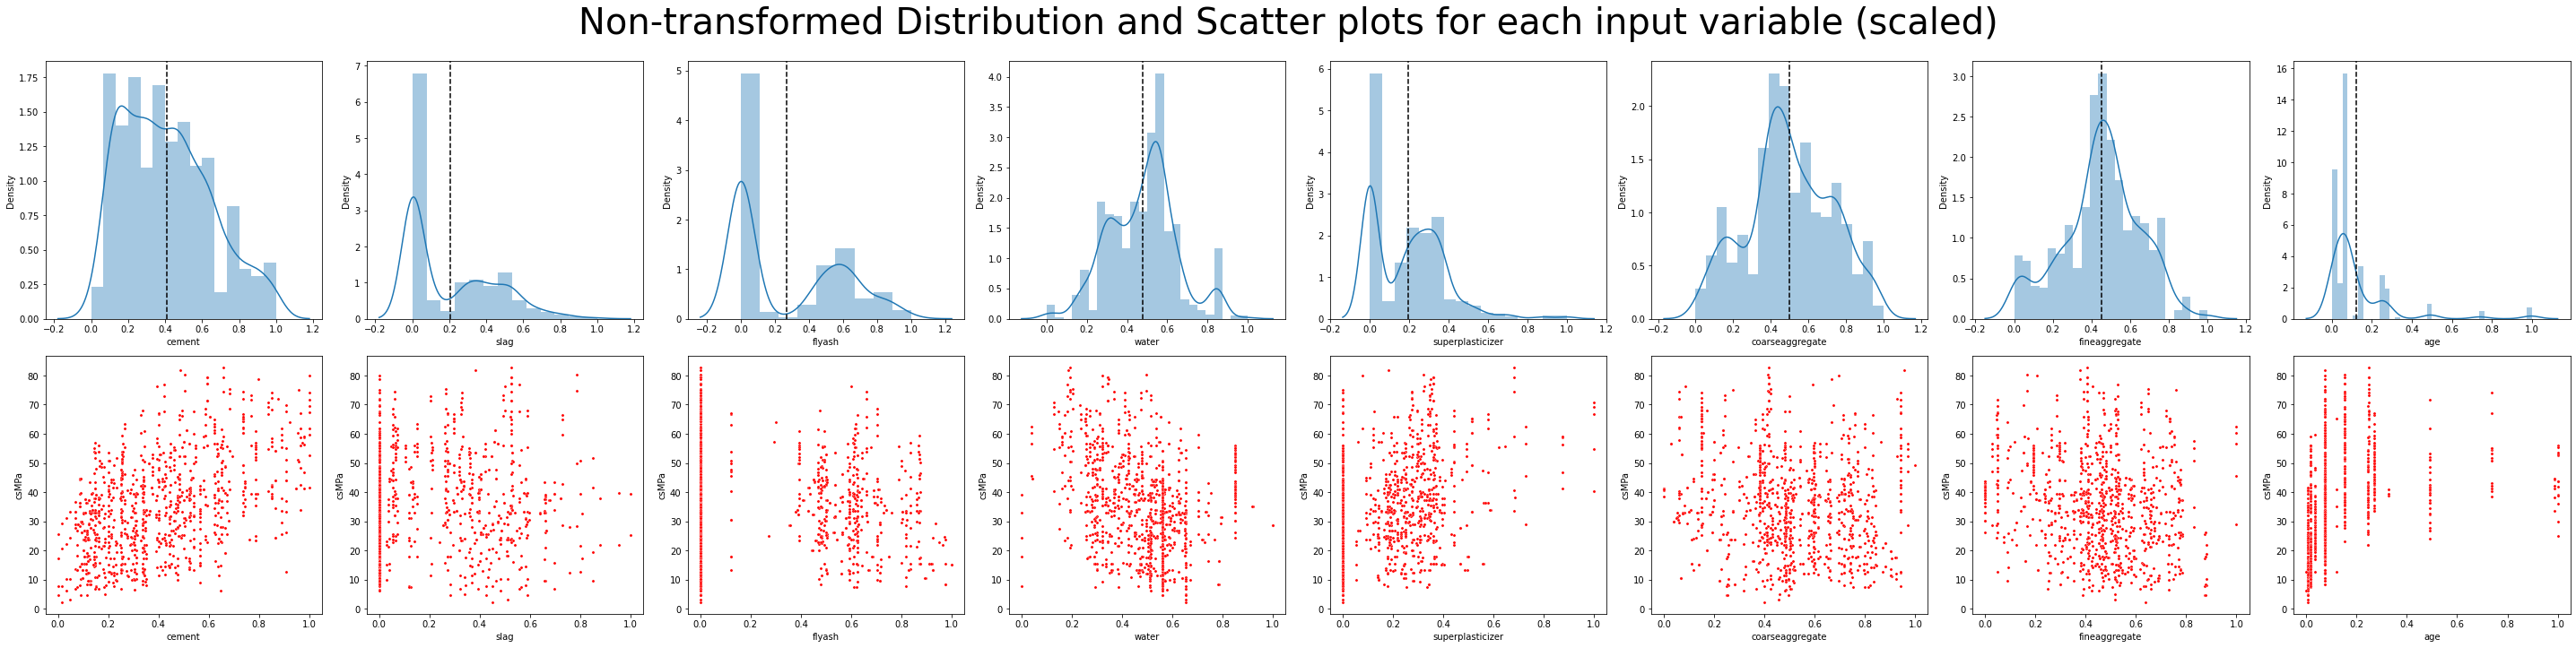

Non-transformed skewness data
            Variable  Skewness
0            cement  0.508739
1              slag  0.809448
2            flyash  0.539377
3             water  0.069111
4  superplasticizer  0.902125
5   coarseaggregate -0.032073
6     fineaggregate -0.254057
7               age  3.280133


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.409059,0.204977,0.270479,0.476887,0.193164,0.498994,0.450823,0.122053,35.817961
std,0.238599,0.239215,0.319652,0.168050,0.184023,0.225753,0.200444,0.171220,16.705742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.330000
25%,0.206336,0.000000,0.000000,0.344249,0.000000,0.380814,0.349348,0.016484,23.710000
50%,0.390183,0.061213,0.000000,0.504792,0.197205,0.485465,0.464877,0.074176,34.445000
75%,0.566210,0.396494,0.591204,0.560703,0.315994,0.663227,0.577020,0.151099,46.135000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,82.600000


In [5]:
scaler = MinMaxScaler()
df = {'Variable': [], 'Skewness': []}
CD.iloc[:,:-1] = scaler.fit_transform(CD.iloc[:,:-1]) # Scales all input variables

fig, axs = plt.subplots(2, 8, figsize=(40, 10))
fig.suptitle('Non-transformed Distribution and Scatter plots for each input variable (scaled)', y = 1, fontsize = 40)

for i, input in enumerate(CD.columns[:-1]):
    df['Variable'].append(input)
    
    sns.distplot(CD[input], ax=axs[0, i])
    axs[0,i].axvline(CD[input].mean(),linestyle="dashed",label="mean", color='black')
    df['Skewness'].append(skew(CD[input]))

    sns.scatterplot(x=CD[input], y=CD['csMPa'], ax=axs[1, i], color = 'red', s = 10)
    #m,b = np.polyfit(CD[input], CD['csMPa'], 1)
    #axs[1,i].plot(CD[input], m*CD[input] + b, color='black', linestyle= 'dashed')

plt.tight_layout()
plt.show()
# To show the general statistics of the scaled CD data for each variable.
print('Non-transformed skewness data\n', pd.DataFrame(df)) # Evaluates variable skewness.
CD.describe() 

## *Interpreting the pre-processed data*
Looking at all the evidence (correlation matrix, distribution plots, scatter graphs, skewness results and the scaled DataFrame), it was best to proceed with the following variables, including brief reasons.
- **Cement**: Square Root transformation - the distribution plot becomes slightly more gaussian; the frequency of cement values below the mean.
- **Slag**: Logarithmic transformation - emphasises the frequency of non zero values; the distribution becomes more normalised.
- **Flyash**: <u>REMOVED</u> - was causing multicolinearity with other input variables and has the lowest gradient relationship with compressive strength. The scatter plot supports this as there is a lot of noise in its data.
- **Water**: No transformation - The skewness result was close to zero, signifying near-perfect normality of data.
- **Superplasticizer**: Square Root transformation - a strong positive trend occurs at low superplasticizer values; becomes less clear if it continues at higher values.
- **Coarse aggregate**: No transformation - no defined trend was seen, there was a wide spread of data points.
- **Fine aggregate**: No transformation - slight negative correlation with compressive strength and was quite linear as it is.
- **Age**: Logarithmic transformation - a curved increase in strength with a slight plateau seen in scatter plot.

**These transformations are seen in the following code below.**

##### *Extra considerations and clarifications*
1. By applying appropriate transformations to columns (square root, logarithmic and reciprocal), this leads to a more defined distibution plot with the data we have from the document. We can generally observe that the closer these plots are to the normal gaussian distribution, the closer the data is to the ideal linear relationship between the input variable and the compressive strength.

2. A few distribution plots, particularly slag, flyash and superplasticizer, have 2 gaussians. This is due to the high amount of 0 values provided from the document. This would skew the regression fit and not represent a reasonable trend with the compreessive strength.

3. Sknewness values were used because, for linear relationships, it assumes a normalised distribution of data.

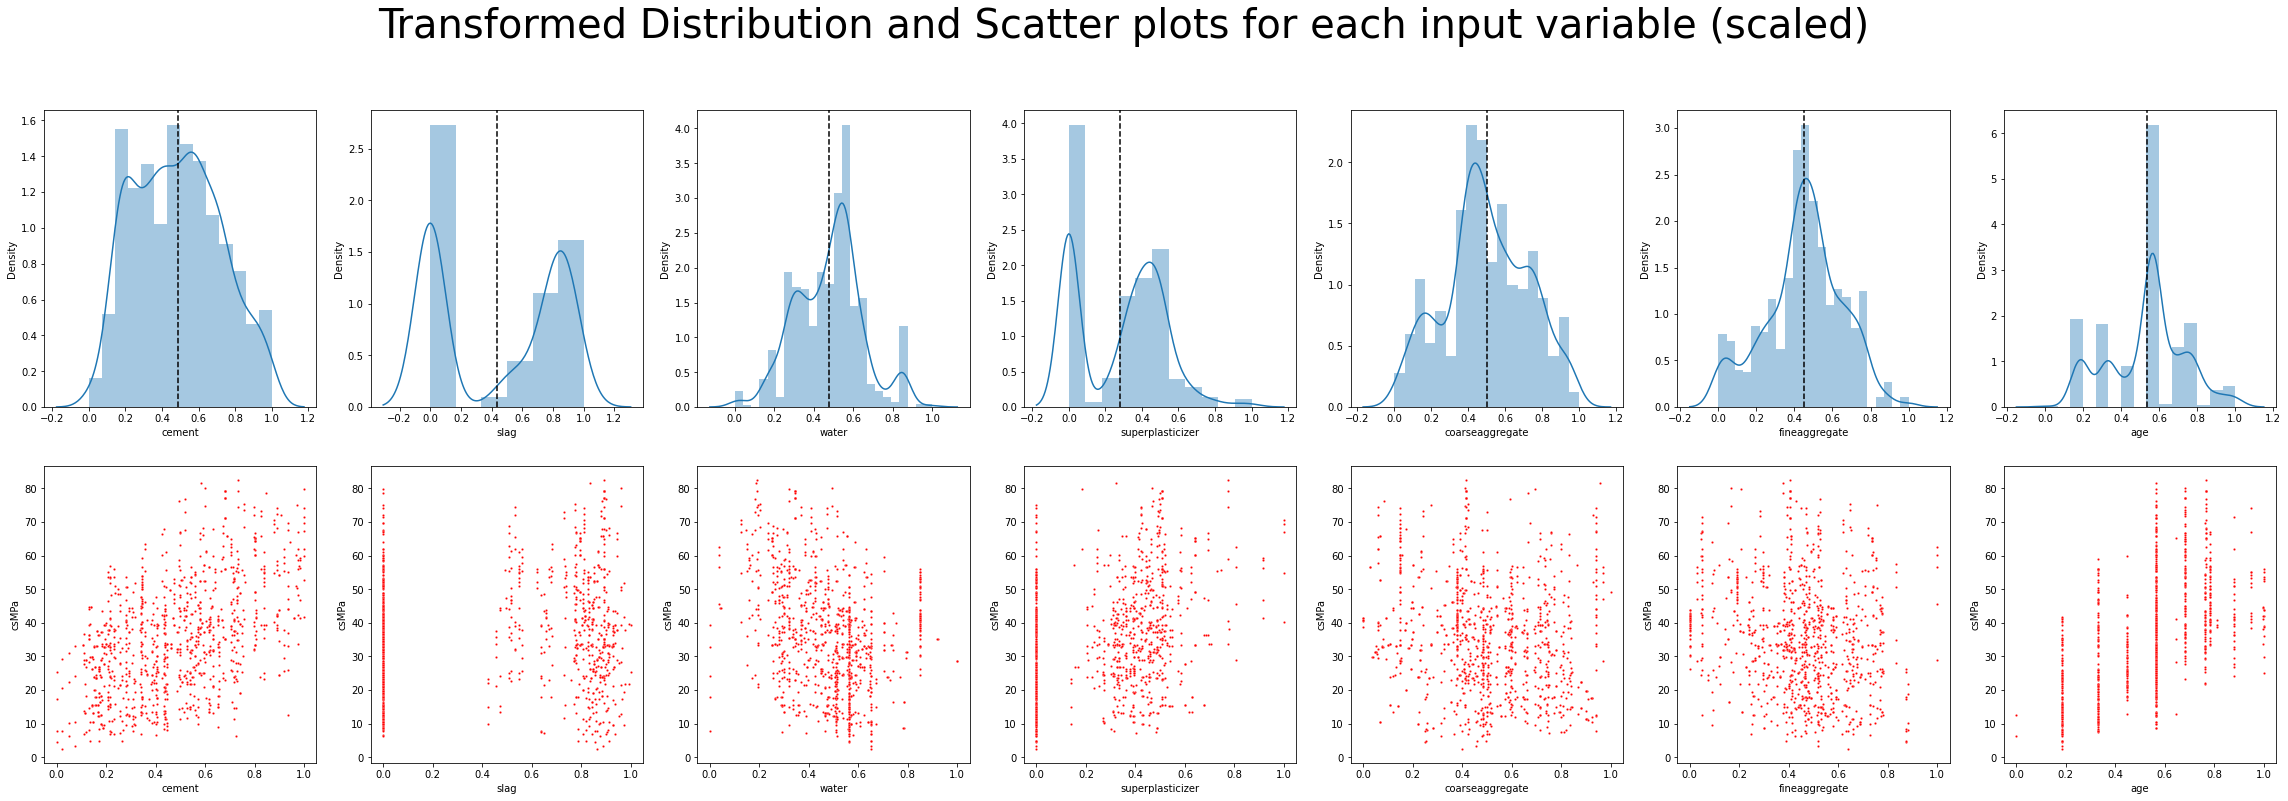

Transformed skewness data
            Variable  Skewness
0            cement  0.189916
1              slag -0.039633
2             water  0.069111
3  superplasticizer  0.106626
4   coarseaggregate -0.032073
5     fineaggregate -0.254057
6               age -0.166173


,cement,slag,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.485582,0.434670,0.476887,0.281564,0.498994,0.450823,0.537250,35.817961
std,0.235961,0.408962,0.168050,0.237012,0.225753,0.200444,0.200750,16.705742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.330000
25%,0.286976,0.000000,0.344249,0.000000,0.380814,0.349348,0.329821,23.710000
50%,0.488658,0.532594,0.504792,0.338799,0.485465,0.464877,0.564790,34.445000
75%,0.655238,0.843580,0.560703,0.463929,0.663227,0.577020,0.682275,46.135000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,82.600000


In [6]:
TCD.iloc[:,:-1] = scaler.fit_transform(TCD.iloc[:,:-1])
columns_to_drop = ['flyash']
columns_to_drop = [col for col in columns_to_drop if col in TCD.columns] # Check if columns exist
TCD.drop(columns_to_drop, axis=1, inplace=True) # Removes the columns that were transformed.

df = {'Variable': [], 'Skewness': []}
fig, axs = plt.subplots(2, (len(TCD.columns)-1), figsize=(40, 12))
fig.suptitle('Transformed Distribution and Scatter plots for each input variable (scaled)', y = 1, fontsize = 40)

for i, input in enumerate(TCD.columns[:-1]):
    df['Variable'].append(input)

    sns.distplot(TCD[input], ax=axs[0, i])
    axs[0,i].axvline(TCD[input].mean(),linestyle="dashed",label="mean", color='black')
    df['Skewness'].append(skew(TCD[input]))

    sns.scatterplot(x=TCD[input], y=TCD['csMPa'], ax=axs[1, i], color = 'red', s = 5)
    #m,b = np.polyfit(TCD[input], TCD['csMPa'], 1)
    #axs[1,i].plot(TCD[input], m*TCD[input] + b, color='black', linestyle= 'dashed')

#plt.tight_layout()
plt.show()

print('Transformed skewness data\n', pd.DataFrame(df))
TCD.describe() # Shows the general statistics of the scaled TCD data for each variable.

# **Regression Model**
The following regression models were considered : Linear, Ridge, Lasso, RandomForest and Support Vector regression (SVR).
- We use test_size = 0.2 to provide the optimal regressions and their scores - it does not deduce which regressions will be excluded.

In [7]:
# Splitting the DataFrame into training and testing sets using sklearn's train_test_split function.
X = TCD.iloc[:,:-1].to_numpy() 
y = TCD['csMPa'].to_numpy()

print(f'y:\n{y}\n')
print(f'X:\n{pd.DataFrame(X)}\n') # Checking the data is split correctly (X = 2D array, y = 1D array).

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y:
[79.99 61.89 40.27 ... 23.7  32.77 32.4 ]

X:
             0         1         2         3         4         5         6
0     1.000000  0.000000  0.321086  0.181994  0.694767  0.205720  0.564790
1     1.000000  0.000000  0.321086  0.181994  0.738372  0.205720  0.564790
2     0.619184  0.843580  0.848243  0.000000  0.380814  0.000000  0.948902
3     0.619184  0.843580  0.848243  0.000000  0.380814  0.000000  0.646810
4     0.303922  0.831183  0.560703  0.000000  0.515698  0.580783  0.997662
...        ...       ...       ...       ...       ...       ...       ...
1025  0.496695  0.808901  0.461661  0.424316  0.200872  0.437280  0.564790
1026  0.597518  0.000000  0.592652  0.470744  0.049128  0.550426  0.564790
1027  0.158813  0.839870  0.566294  0.329850  0.265698  0.466633  0.564790
1028  0.191346  0.889189  0.429712  0.497525  0.548256  0.488961  0.564790
1029  0.460703  0.784761  0.629393  0.414726  0.184593  0.420221  0.564790

[1030 rows x 7 columns]



In [8]:
# Checking the shape of both the training and testing sets are reasonable.
print(y_test.shape, y_train.shape, x_test.shape, x_train.shape)

(206,) (824,) (206, 7) (824, 7)


In [11]:
class RegressionModel:
    '''The aim of this class is to successfully fit the regression model to the training data, predict the y values for the 
    testing data, and evaluate the model using the specified metrics and scores. The regressions can be visualised with plots.'''
    def __init__(self, x_train, x_test, y_train, y_test, regression, **kwargs):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.regression = regression(**kwargs)                  # Initiates regression method with any required arguments.
        self.regfit = self.regression.fit(x_train, y_train)     # Fits the regression method to the training data.
        self.y_pred = self.regression.predict(x_test)           # Predicts the y values for the testing data.
    
    def Metric(self, metriclist) -> pd.DataFrame:
        # Evaluates the regression model error analysis using the specified metrics.
        metricdf = {'Metric': [], 'Score': []}
        for metric in metriclist:
            metricdf['Metric'].append(metric.__name__)
            if metric == cross_val_score:
                metricdf['Score'].append(metric(self.regression, self.x_train, self.y_train, cv=5).mean())        # Takes the mean of the 
                                                                                                                  # cross validation scores.
            else:
                metricdf['Score'].append(metric(self.y_test, self.y_pred))
        return pd.DataFrame(metricdf)
    
    def RegScores(self):
        # Compares the regression model scores for the training and testing data.
        return self.regression.score(self.x_test, self.y_test), self.regression.score(self.x_train, self.y_train)

    def Plot(self):
        # To help visualise the regression model with the given parameters.
        plt.figure(figsize=(6, 4))
        plt.scatter(self.y_test, self.y_pred, color='red', s=5)
        plt.title(f'{self.regression.__class__.__name__} - Score: {self.regression.score(self.x_test, self.y_test)}')
        plt.plot(y_test,y_test, color='black', linestyle = 'dashed')
        plt.xlabel('Actual csMPa')
        plt.ylabel('Predicted csMPa')
        plt.show()
        return

### *Finding the best parameters / hyperparameters for each model using cross validation*

Cross validation scores for LinearRegression (normalised): 0.791861750187415


Text(69.0, 0.5, 'Alpha')

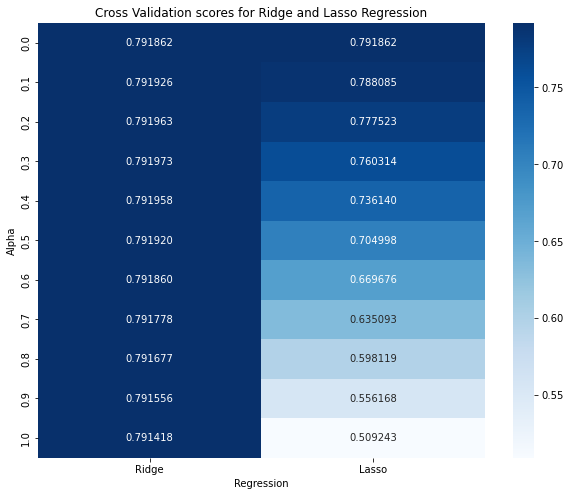

In [12]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metriclist = [RMSE, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, cross_val_score]

'''Linear Regression'''
model = RegressionModel(x_train, x_test, y_train, y_test, LinearRegression, normalize = True)
cv1_score = model.Metric(metriclist).loc[model.Metric(metriclist)['Metric'] == 'cross_val_score', 'Score'].values[0]
print(f"Cross validation scores for LinearRegression (normalised): {cv1_score}")

'''Ridge and Lasso Regression'''
CrossValscores = np.zeros((len(alphas), 2))
for i, regression in enumerate([Ridge, Lasso]):
    for j, alpha in enumerate(alphas):
        if i == 0:
            model = RegressionModel(x_train, x_test, y_train, y_test, regression, alpha = alpha)
        else:
            model = RegressionModel(x_train, x_test, y_train, y_test, regression, alpha = alpha, max_iter = 10000)
        metric_df = model.Metric(metriclist)
        cv_score = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]
        CrossValscores[j][i] = cv_score

# Plotting a heatmap of the cross validation scores for Ridge and Lasso regression.
CrossVal_df = pd.DataFrame(CrossValscores, index=alphas, columns=['Ridge', 'Lasso'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(CrossVal_df, annot=True, fmt=".6f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for Ridge and Lasso Regression')
ax.set_xlabel('Regression')
ax.set_ylabel('Alpha')

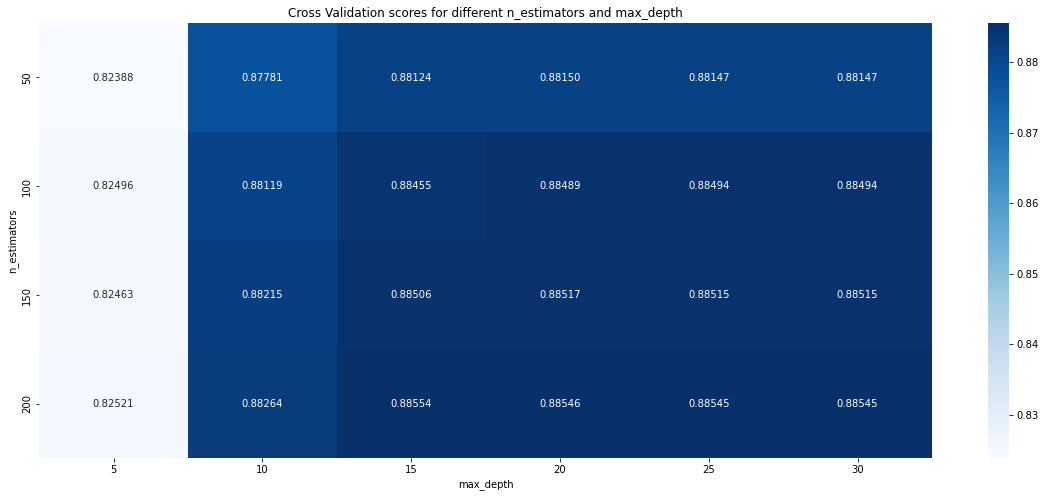

In [13]:
'''Random Forest Regression'''
# Only operate if needed - This bit will take longer than usual to run.

RFscore_values = [[0 for _ in range(6)] for _ in range(4)]
for i, n_estimators in enumerate([50,100,150,200]):
    for j, max_depth in enumerate([5,10,15,20,25,30]):
        #print(f'n_estimators = {n_estimators}, max_depth = {max_depth}')
        metric_df = RegressionModel(x_train, x_test, y_train, y_test, RandomForestRegressor, n_estimators = n_estimators, max_depth = max_depth, random_state = 42).Metric(metriclist)
        RFscore_values[i][j] = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]

# Plotting a heatmap of the cross validation scores for different n_estimators and max_depth.
RFscore_df = pd.DataFrame(RFscore_values, index=[50,100,150,200], columns=[5,10,15,20,25,30])
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(RFscore_df, annot=True, fmt=".5f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for different n_estimators and max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
plt.show()

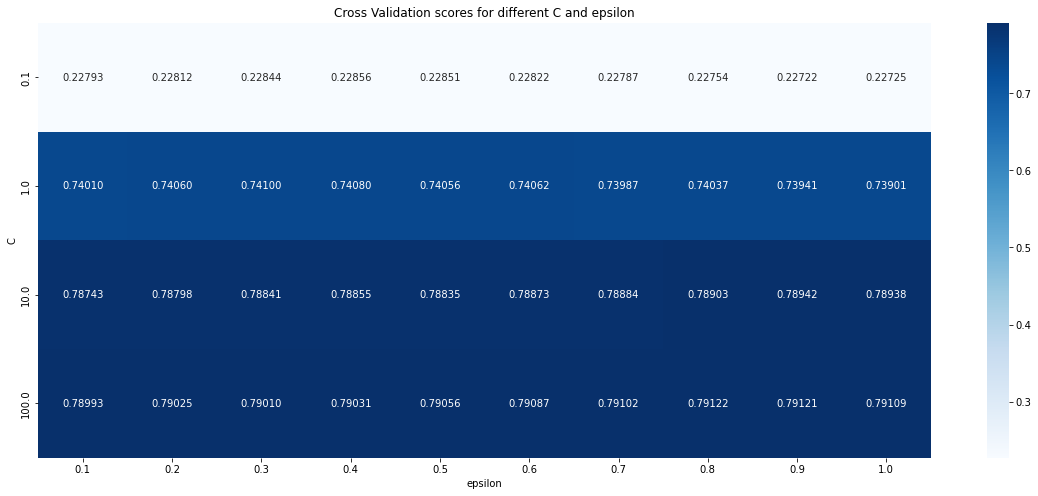

In [14]:
'''Support Vector Regression'''
SVRscore_values = np.zeros((4,10)) #2D array
for i, c in enumerate([0.1, 1, 10, 100]):
    for j, epsilon in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        #print(f'n_estimators = {n_estimators}, max_depth = {max_depth}')
        metric_df = RegressionModel(x_train, x_test, y_train, y_test, SVR, kernel = 'linear', C = c, epsilon = epsilon).Metric(metriclist) 
        SVRscore_values[i][j] = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]

# Plotting a heatmap of the cross validation scores for different C and epsilon.
SVRscore_df = pd.DataFrame(SVRscore_values, index=[0.1, 1, 10, 100], columns=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(SVRscore_df, annot=True, fmt=".5f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for different C and epsilon')
ax.set_xlabel('epsilon')
ax.set_ylabel('C')
plt.show()

#### <u>Observations</u>
For Lasso Regression, the best cross validation score was when alpha = 0, this does not need to be considered anymore because behaves exactly like LinearRegression. Here are the best parameters from each remaining regression:
- Linear: N/A
- Ridge: alpha = 0.2
- RandomForest: n_estimators = 100, max_depth = 25
- SVR: C = 100, epsilon = 0.7

### *Plotting the models with the best parameters*

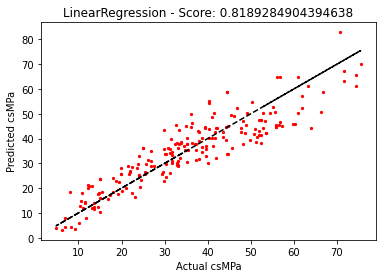

(0.8189284904394638, 0.7964650009002096)
                     Metric      Score
0                      RMSE   6.830662
1        mean_squared_error  46.657944
2                  r2_score   0.818928
3       mean_absolute_error   5.555046
4  explained_variance_score   0.819213
5           cross_val_score   0.791862


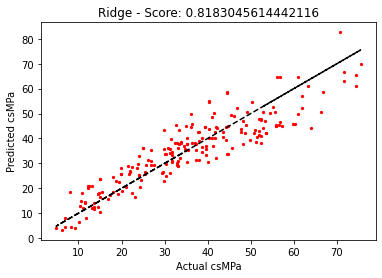

(0.8183045614442116, 0.7963938248228054)
                     Metric      Score
0                      RMSE   6.842420
1        mean_squared_error  46.818716
2                  r2_score   0.818305
3       mean_absolute_error   5.563811
4  explained_variance_score   0.818592
5           cross_val_score   0.791973


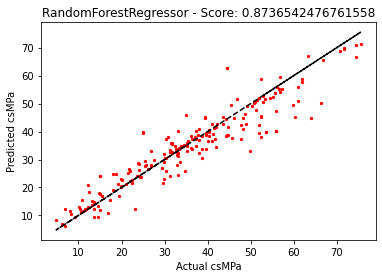

(0.8736542476761558, 0.9835573601152371)
                     Metric      Score
0                      RMSE   5.705820
1        mean_squared_error  32.556381
2                  r2_score   0.873654
3       mean_absolute_error   3.927842
4  explained_variance_score   0.876428
5           cross_val_score   0.885541


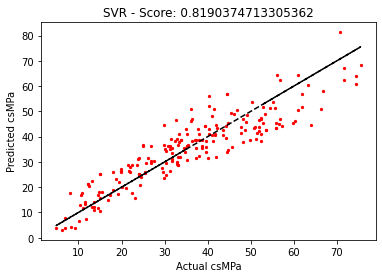

(0.8190374713305362, 0.7938121001631264)
                     Metric      Score
0                      RMSE   6.828606
1        mean_squared_error  46.629862
2                  r2_score   0.819037
3       mean_absolute_error   5.511969
4  explained_variance_score   0.819338
5           cross_val_score   0.791219


In [16]:
regressors = [LinearRegression, Ridge, RandomForestRegressor, SVR]
metriclist = [RMSE, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, cross_val_score]

for r in regressors:
    if r is LinearRegression:
        model = RegressionModel(x_train, x_test, y_train, y_test, r)
    elif r is Ridge:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, alpha = 0.3, random_state = 42)
    elif r is RandomForestRegressor:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, n_estimators = 200, max_depth = 15, random_state = 42)
    else:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, kernel = 'linear', C = 100, epsilon = 0.8)
    model.Plot()
    print(model.RegScores())            # To compare the regression model scores for the training and testing data.
    print(model.Metric(metriclist))     # To evaluate the regression model error analysis using the specified metrics.

### Final Observations
With reference to the link below, our model provides a 'Good' score, with predicted scores within 80-90% across all regression models. This means our transformations our rather correct to what actual relationships are between input variables and the compressive strength - the scores can be increased if we precisely find the right relationships. Below is our interpretation from the models.

Ensemble methods are too complex to help us find coefficients. 
- There is a large difference in scores in Random Forest (RF) - given our approach across this code that each variable has a linear relationship with the variables (with applied transformations), this model isn't suitable. To further support this, RF works in a way to provide the best possible fit including the noise from different variables.
- SVM was more acceptable and comparable to Linear and Ridge. Despite having a better regression score and error analysis in general, the hyperparameters make it difficult to interpret the important features to find the coefficients. Therefore a simpler model would be better.

Its a very close judgement between the Linear and Ridge on which one is best, so I will leave it up to you what you think about them.

(**Important**: If you three could find any reason to support or reject my analysis, add them here.)

Reference link: https://stephenallwright.com/good-accuracy-score/#:~:text=There%20is%20a%20general%20rule%20when%20it%20comes,and%2070%25%20-%20OK%20Below%2060%25%20-%20Poor

Let me know of any changes or anything you have in mind <3
Mervyn